# Мастерская. Разработка модели машинного обчения для предсказания риска сердечного приступа. 

Решены следующие задачи:
•	
- Проведено исследование датасета  с данными пациентов, с поиском дополнительной информации для лучшего понимания природы данных.
- 	Произведена предобработка данных. 
-	Обучение модели
-	Подготовка предсказания на тестовой выборке. 
-	Подготовка скриптов и библиотеки для обработки данных и предсказания на тестовой выборке
-	Написание инструмента для тестирования
-	Оформление документации


In [1]:
!pip install catboost -q

In [2]:

!pip install imbalanced-learn -q

In [3]:
!pip install phik -q

In [4]:
import warnings
warnings.filterwarnings('ignore')  # окключить предупреждения

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, f1_score, confusion_matrix
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [6]:
import phik

## Загрузка данных

### Данные тренировочной выборки

In [7]:
dd = r"C:\Users\Alex\Desktop\masterskay\heart_train.csv"
df = pd.read_csv(dd)
df.head()


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [8]:
df.columns

Index(['Unnamed: 0', 'Age', 'Cholesterol', 'Heart rate', 'Diabetes',
       'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption',
       'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems',
       'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income',
       'BMI', 'Triglycerides', 'Physical Activity Days Per Week',
       'Sleep Hours Per Day', 'Heart Attack Risk (Binary)', 'Blood sugar',
       'CK-MB', 'Troponin', 'Gender', 'Systolic blood pressure',
       'Diastolic blood pressure', 'id'],
      dtype='object')

#### Сортировка данных

In [9]:
df_train = df.drop('Unnamed: 0', axis=1)
df_train.set_index('id', inplace=True)
df_train = df_train.sort_values('id')
df_train.head()


,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,,,
1,0.595506,0.096429,0.047663,1.0,1.0,1.0,1.0,1.0,0.752420,1,...,0.276623,2.0,0.666667,0.0,0.227018,0.048229,0.036512,Male,0.574194,0.569767
2,0.595506,0.189286,0.047663,0.0,0.0,1.0,0.0,1.0,0.200998,2,...,0.057143,4.0,1.000000,0.0,0.227018,0.048229,0.036512,Male,0.187097,0.674419
4,0.078652,0.792857,0.071494,1.0,0.0,1.0,1.0,0.0,0.601030,2,...,0.768831,1.0,0.166667,0.0,0.227018,0.048229,0.036512,Male,0.251613,0.383721
5,0.078652,0.771429,0.071494,1.0,1.0,1.0,0.0,1.0,0.658864,2,...,0.485714,2.0,0.666667,0.0,0.227018,0.048229,0.036512,Male,0.735484,0.383721
6,0.078652,0.492857,0.071494,1.0,0.0,1.0,0.0,0.0,0.849607,1,...,0.407792,0.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.419355,0.720930


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8685 entries, 1 to 9650
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level        

In [11]:
def сhecking_values (df):  # функция для просмотра значений 
    columns = df.columns
    for i, column in enumerate(columns):
        if df[column].dtypes=='object':
            display(f'Уникальные значения {column}:{df[column].unique()}')
        else:   
            if df[column].nunique()>20:
                display(f'Кол-во значений {column}:{df[column].nunique()}')
            else:
                display(f'Уникальные значения {column}:{sorted(df[column].unique())}')   

In [12]:
сhecking_values(df_train)

'Кол-во значений Age:77'

'Кол-во значений Cholesterol:282'

'Кол-во значений Heart rate:87'

'Уникальные значения Diabetes:[0.0, 1.0, nan]'

'Уникальные значения Family History:[0.0, 1.0, nan]'

'Уникальные значения Smoking:[0.0, 1.0, nan]'

'Уникальные значения Obesity:[0.0, 1.0, nan]'

'Уникальные значения Alcohol Consumption:[0.0, 1.0, nan]'

'Кол-во значений Exercise Hours Per Week:7933'

'Уникальные значения Diet:[0, 1, 2, 3]'

'Уникальные значения Previous Heart Problems:[0.0, 1.0, nan]'

'Уникальные значения Medication Use:[0.0, 1.0, nan]'

'Уникальные значения Stress Level:[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]'

'Кол-во значений Sedentary Hours Per Day:7933'

'Кол-во значений Income:7808'

'Кол-во значений BMI:7933'

'Кол-во значений Triglycerides:772'

'Уникальные значения Physical Activity Days Per Week:[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]'

'Уникальные значения Sleep Hours Per Day:[0.0, 0.1666666666666666, 0.3333333333333333, 0.4999999999999999, 0.5046212363584658, 0.6666666666666666, 0.8333333333333334, 1.0]'

'Уникальные значения Heart Attack Risk (Binary):[0.0, 1.0]'

'Кол-во значений Blood sugar:239'

'Кол-во значений CK-MB:679'

'Кол-во значений Troponin:340'

"Уникальные значения Gender:['Male' 'Female' '1.0' '0.0']"

'Кол-во значений Systolic blood pressure:100'

'Кол-во значений Diastolic blood pressure:66'

In [13]:
df_train.isna().sum()  # Проверка пропусков

Age                                  0
Cholesterol                          0
Heart rate                           0
Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Exercise Hours Per Week              0
Diet                                 0
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Sedentary Hours Per Day              0
Income                               0
BMI                                  0
Triglycerides                        0
Physical Activity Days Per Week    243
Sleep Hours Per Day                  0
Heart Attack Risk (Binary)           0
Blood sugar                          0
CK-MB                                0
Troponin                             0
Gender                               0
Systolic blood pressure              0
Diastolic blood pressure 

Проверка данных по Gender, имеющие значения 0 и 1

In [14]:
df_gender_train = df_train.loc[df_train['Gender'].isin(['0.0', '1.0'])]
df_gender_train.head()


,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,,,
9377,0.516854,0.49978,0.065995,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.0,0.525692,0.004268,0.000388,1.0,0.554839,0.418605
9378,0.516854,0.49978,0.065995,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.0,0.112648,0.005002,0.000680,1.0,0.458065,0.313953
9379,0.516854,0.49978,0.065995,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.0,0.140316,0.024723,0.003690,0.0,0.554839,0.418605
9380,0.382022,0.49978,0.105408,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.0,0.128458,0.315234,0.000291,1.0,0.212903,0.209302
9381,0.370787,0.49978,0.042163,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.0,0.482213,1.000000,0.000583,0.0,0.445161,0.174419


In [15]:
df_gender_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 9377 to 9650
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              243 non-null    float64
 1   Cholesterol                      243 non-null    float64
 2   Heart rate                       243 non-null    float64
 3   Diabetes                         0 non-null      float64
 4   Family History                   0 non-null      float64
 5   Smoking                          0 non-null      float64
 6   Obesity                          0 non-null      float64
 7   Alcohol Consumption              0 non-null      float64
 8   Exercise Hours Per Week          243 non-null    float64
 9   Diet                             243 non-null    int64  
 10  Previous Heart Problems          0 non-null      float64
 11  Medication Use                   0 non-null      float64
 12  Stress Level      

In [16]:
сhecking_values(df_gender_train)

'Кол-во значений Age:58'

'Уникальные значения Cholesterol:[0.4997802373588872]'

'Кол-во значений Heart rate:63'

'Уникальные значения Diabetes:[nan]'

'Уникальные значения Family History:[nan]'

'Уникальные значения Smoking:[nan]'

'Уникальные значения Obesity:[nan]'

'Уникальные значения Alcohol Consumption:[nan]'

'Уникальные значения Exercise Hours Per Week:[0.5021096428447382]'

'Уникальные значения Diet:[3]'

'Уникальные значения Previous Heart Problems:[nan]'

'Уникальные значения Medication Use:[nan]'

'Уникальные значения Stress Level:[nan]'

'Уникальные значения Sedentary Hours Per Day:[0.4999199316271984]'

'Уникальные значения Income:[0.4948894028003345]'

'Уникальные значения BMI:[0.4947741363416157]'

'Уникальные значения Triglycerides:[0.5036030408750896]'

'Уникальные значения Physical Activity Days Per Week:[nan]'

'Уникальные значения Sleep Hours Per Day:[0.5046212363584658]'

'Уникальные значения Heart Attack Risk (Binary):[0.0]'

'Кол-во значений Blood sugar:120'

'Кол-во значений CK-MB:210'

'Кол-во значений Troponin:103'

"Уникальные значения Gender:['1.0' '0.0']"

'Кол-во значений Systolic blood pressure:78'

'Кол-во значений Diastolic blood pressure:56'

In [17]:
df_train.duplicated().sum()

0

In [18]:
df_gender_train.duplicated().sum()

0

### Вывод 
В данных тренировочной выборки имеется пропущенные значения 243. Все пропущенные значения, находятся в строках, содержащих признак Gender 0 или 1.

### Данных тестовой выборки

In [19]:
dd_2 = r"C:\Users\Alex\Desktop\masterskay\heart_test.csv"
df_test = pd.read_csv(dd_2)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

In [20]:
df_test = df_test.drop('Unnamed: 0', axis=1)
df_test.set_index('id', inplace=True)
df_test = df_test.sort_values('id')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 966 entries, 0 to 9644
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart rate                       966 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          966 non-null    float64
 9   Diet                             966 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level         

In [21]:
сhecking_values(df_test)

'Кол-во значений Age:73'

'Кол-во значений Cholesterol:266'

'Кол-во значений Heart rate:76'

'Уникальные значения Diabetes:[0.0, 1.0, nan]'

'Уникальные значения Family History:[0.0, 1.0, nan]'

'Уникальные значения Smoking:[0.0, 1.0, nan]'

'Уникальные значения Obesity:[0.0, 1.0, nan]'

'Уникальные значения Alcohol Consumption:[0.0, 1.0, nan]'

'Кол-во значений Exercise Hours Per Week:924'

'Уникальные значения Diet:[0, 1, 2, 3]'

'Уникальные значения Previous Heart Problems:[0.0, 1.0, nan]'

'Уникальные значения Medication Use:[0.0, 1.0, nan]'

'Уникальные значения Stress Level:[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]'

'Кол-во значений Sedentary Hours Per Day:924'

'Кол-во значений Income:921'

'Кол-во значений BMI:924'

'Кол-во значений Triglycerides:529'

'Уникальные значения Physical Activity Days Per Week:[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]'

'Уникальные значения Sleep Hours Per Day:[0.0, 0.1666666666666666, 0.3333333333333333, 0.4999999999999999, 0.5046212363584658, 0.6666666666666666, 0.8333333333333334, 1.0]'

'Кол-во значений Blood sugar:124'

'Кол-во значений CK-MB:183'

'Кол-во значений Troponin:96'

"Уникальные значения Gender:['Male' 'Female' '1.0' '0.0']"

'Кол-во значений Systolic blood pressure:93'

'Кол-во значений Diastolic blood pressure:54'

In [22]:
df_gender_test = df_test.loc[df_test['Gender'].isin(['0.0', '1.0'])]
df_gender_test.head(10)

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,,,
9391,0.370787,0.49978,0.056829,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.494774,0.503603,NaN,0.504621,0.199605,0.005970,0.006408,1.0,0.387097,0.220930
9394,0.348315,0.49978,1.000000,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.494774,0.503603,NaN,0.504621,0.146245,0.003367,0.097971,1.0,0.490323,0.616279
9399,0.438202,0.49978,0.054995,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.494774,0.503603,NaN,0.504621,0.302372,0.009740,0.000583,0.0,0.548387,0.116279
9403,0.438202,0.49978,0.048579,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.494774,0.503603,NaN,0.504621,0.128458,0.001548,0.059035,1.0,0.425806,0.302326
9412,0.348315,0.49978,0.054079,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.494774,0.503603,NaN,0.504621,0.207510,0.006137,0.000388,0.0,0.174194,0.151163
9424,0.606742,0.49978,0.048579,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.494774,0.503603,NaN,0.504621,0.134387,0.009240,0.000388,0.0,0.548387,0.383721
9425,0.606742,0.49978,0.048579,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.494774,0.503603,NaN,0.504621,0.126482,0.005770,0.000777,1.0,0.322581,0.348837
9442,0.550562,0.49978,0.040330,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.494774,0.503603,NaN,0.504621,0.098814,0.006904,0.001068,1.0,0.264516,0.302326
9447,0.584270,0.49978,0.043996,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.494774,0.503603,NaN,0.504621,0.150198,0.006337,0.001359,1.0,0.167742,0.220930


In [23]:
df_gender_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 9391 to 9644
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              31 non-null     float64
 1   Cholesterol                      31 non-null     float64
 2   Heart rate                       31 non-null     float64
 3   Diabetes                         0 non-null      float64
 4   Family History                   0 non-null      float64
 5   Smoking                          0 non-null      float64
 6   Obesity                          0 non-null      float64
 7   Alcohol Consumption              0 non-null      float64
 8   Exercise Hours Per Week          31 non-null     float64
 9   Diet                             31 non-null     int64  
 10  Previous Heart Problems          0 non-null      float64
 11  Medication Use                   0 non-null      float64
 12  Stress Level       

### Вывод по данным тестовой выборке.
В данных также имеются пропуски всего 31. Аналогично транировочной выборки пропуски находяться в строках признак Gender имеюий значение 0,1.

## Проверка косвенной утечки целевого признака

In [24]:
df_train_test = df_train.merge(df_test, on='id', how='inner')  #  проверка на совпадение id 
df_train_test.shape

(0, 51)

In [25]:
def df_num_col(df):
    num_col = [col for col in df.select_dtypes(include='number').columns 
                if col != 'id' and df[col].nunique() > 20]
    return num_col    

In [26]:
num_col =df_num_col(df_train)

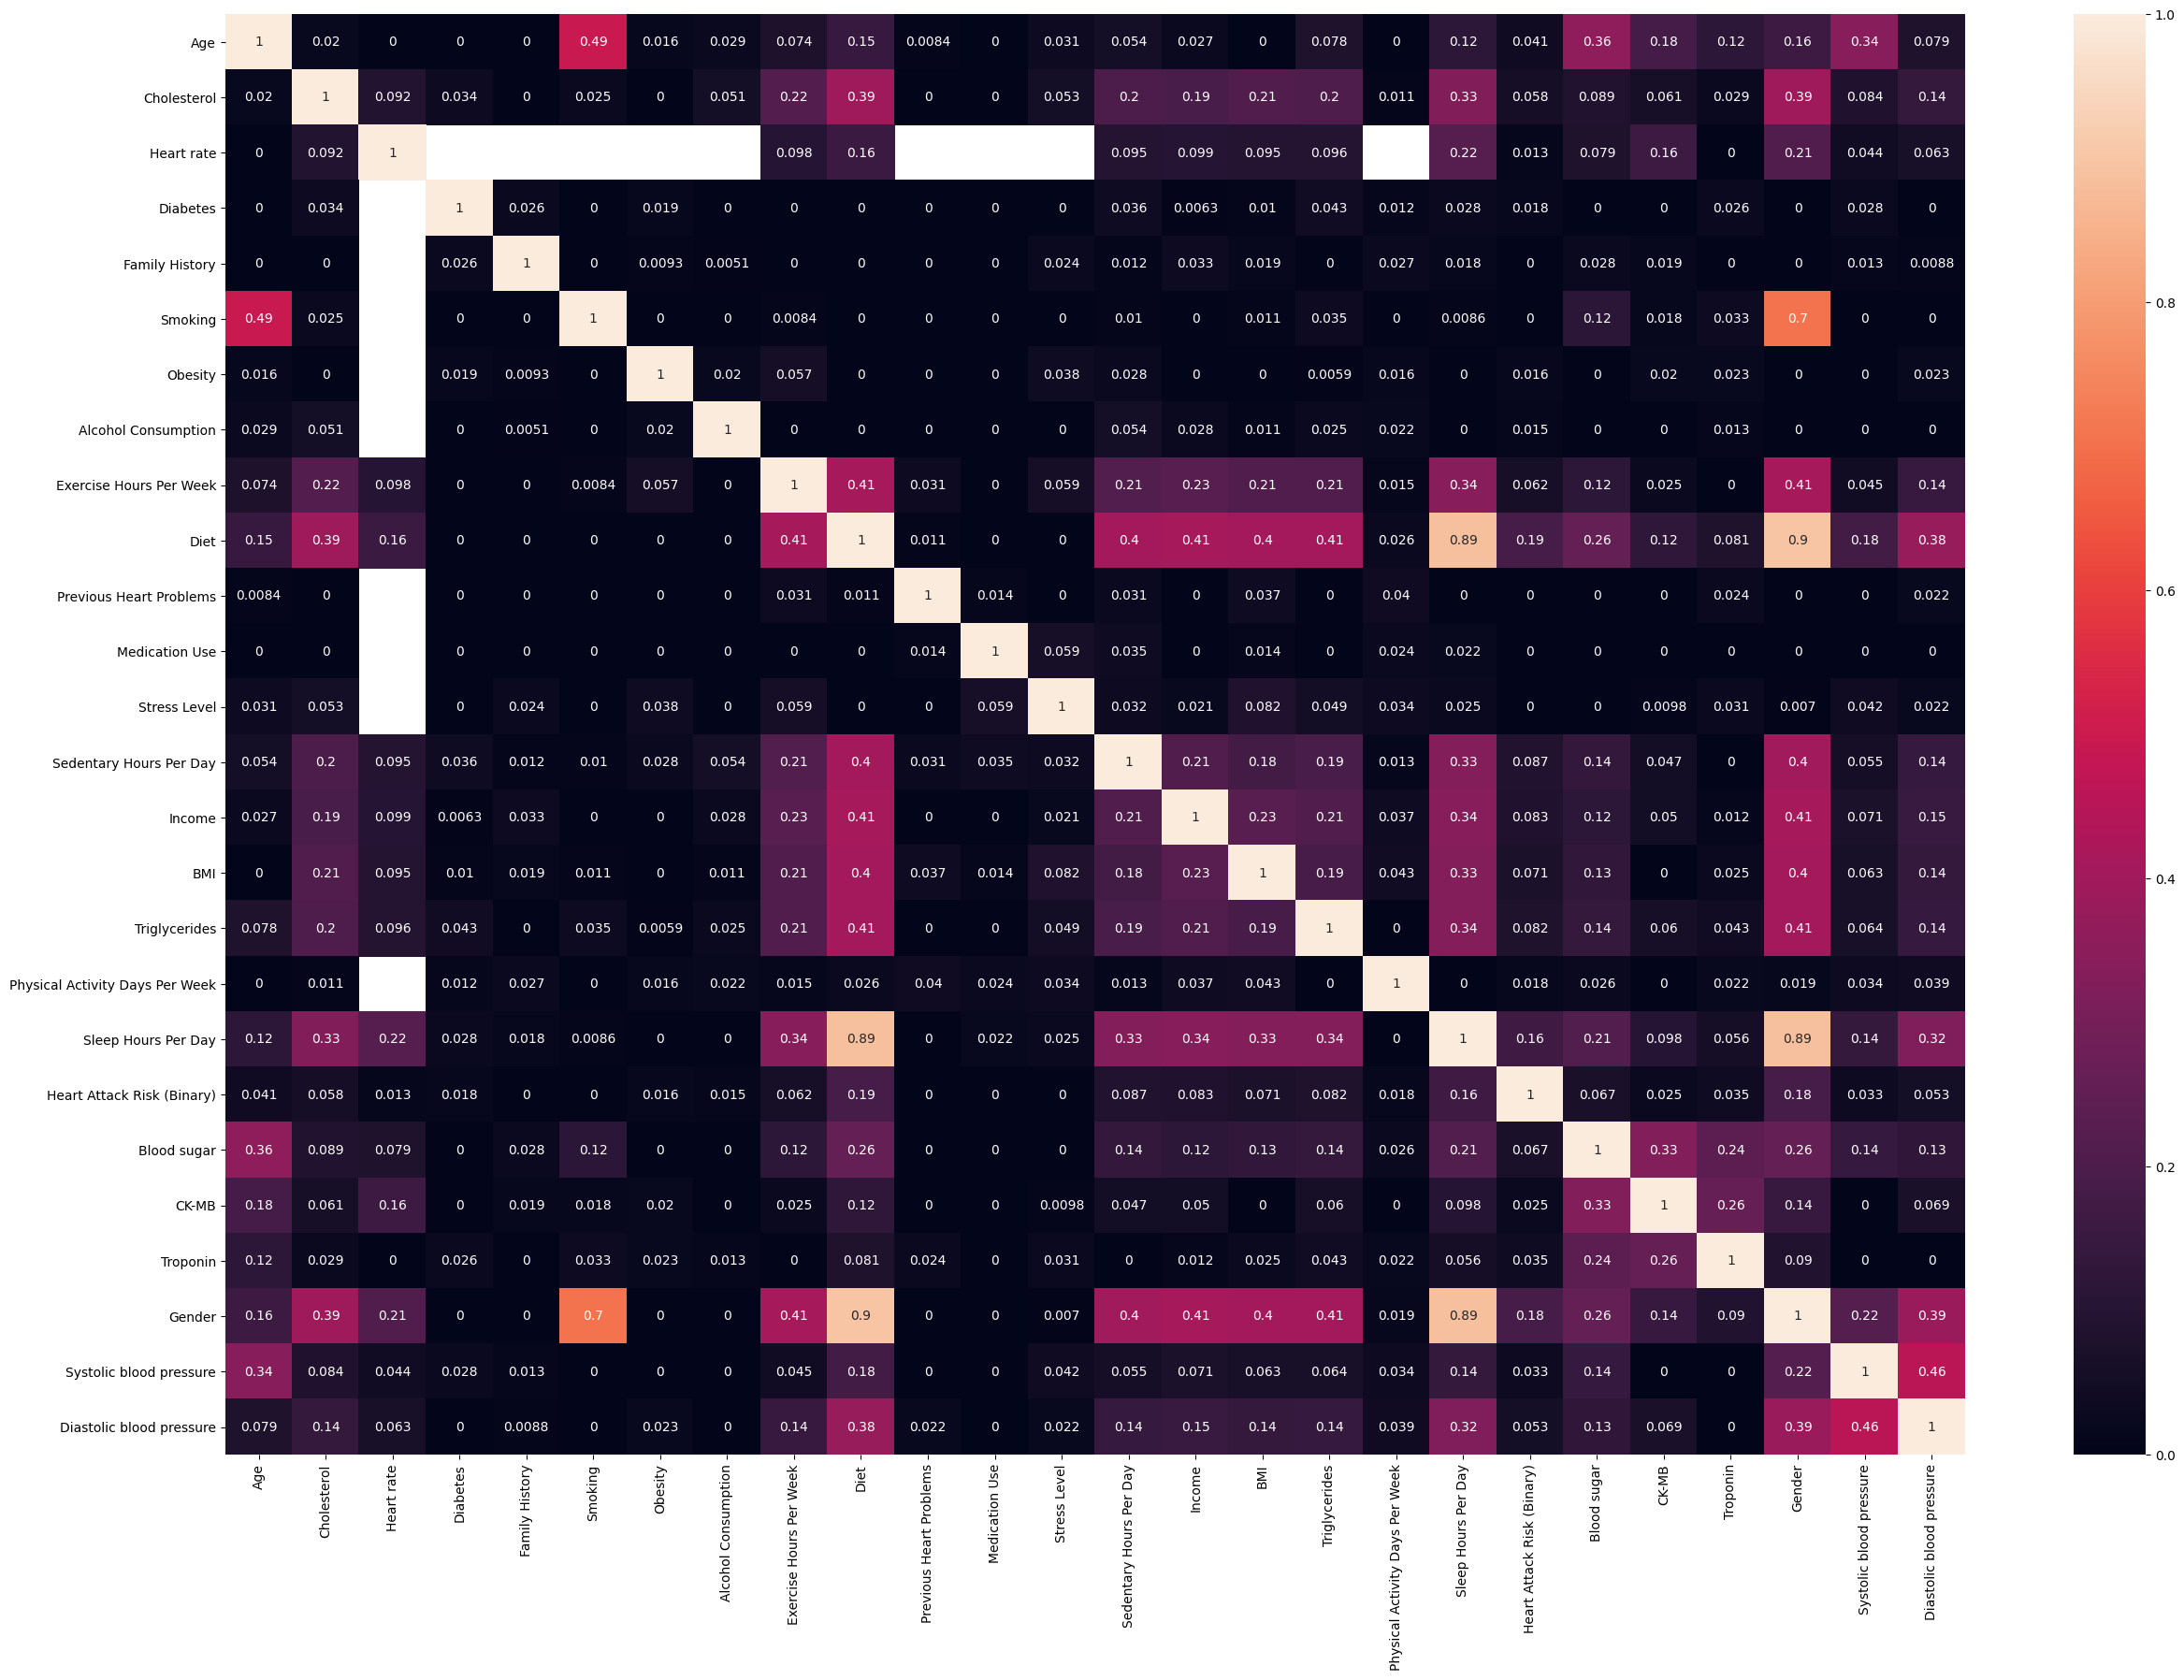

In [27]:
plt.figure(figsize=(30, 20))
sns.heatmap(df_train.phik_matrix(interval_cols=num_col), annot=True) 
plt.show()

In [28]:
#df_train_2 = df_train[df_train['Gender'].isin(['Male', 'Female'])]
df_train_2 = df_train
#df_train_2.info()

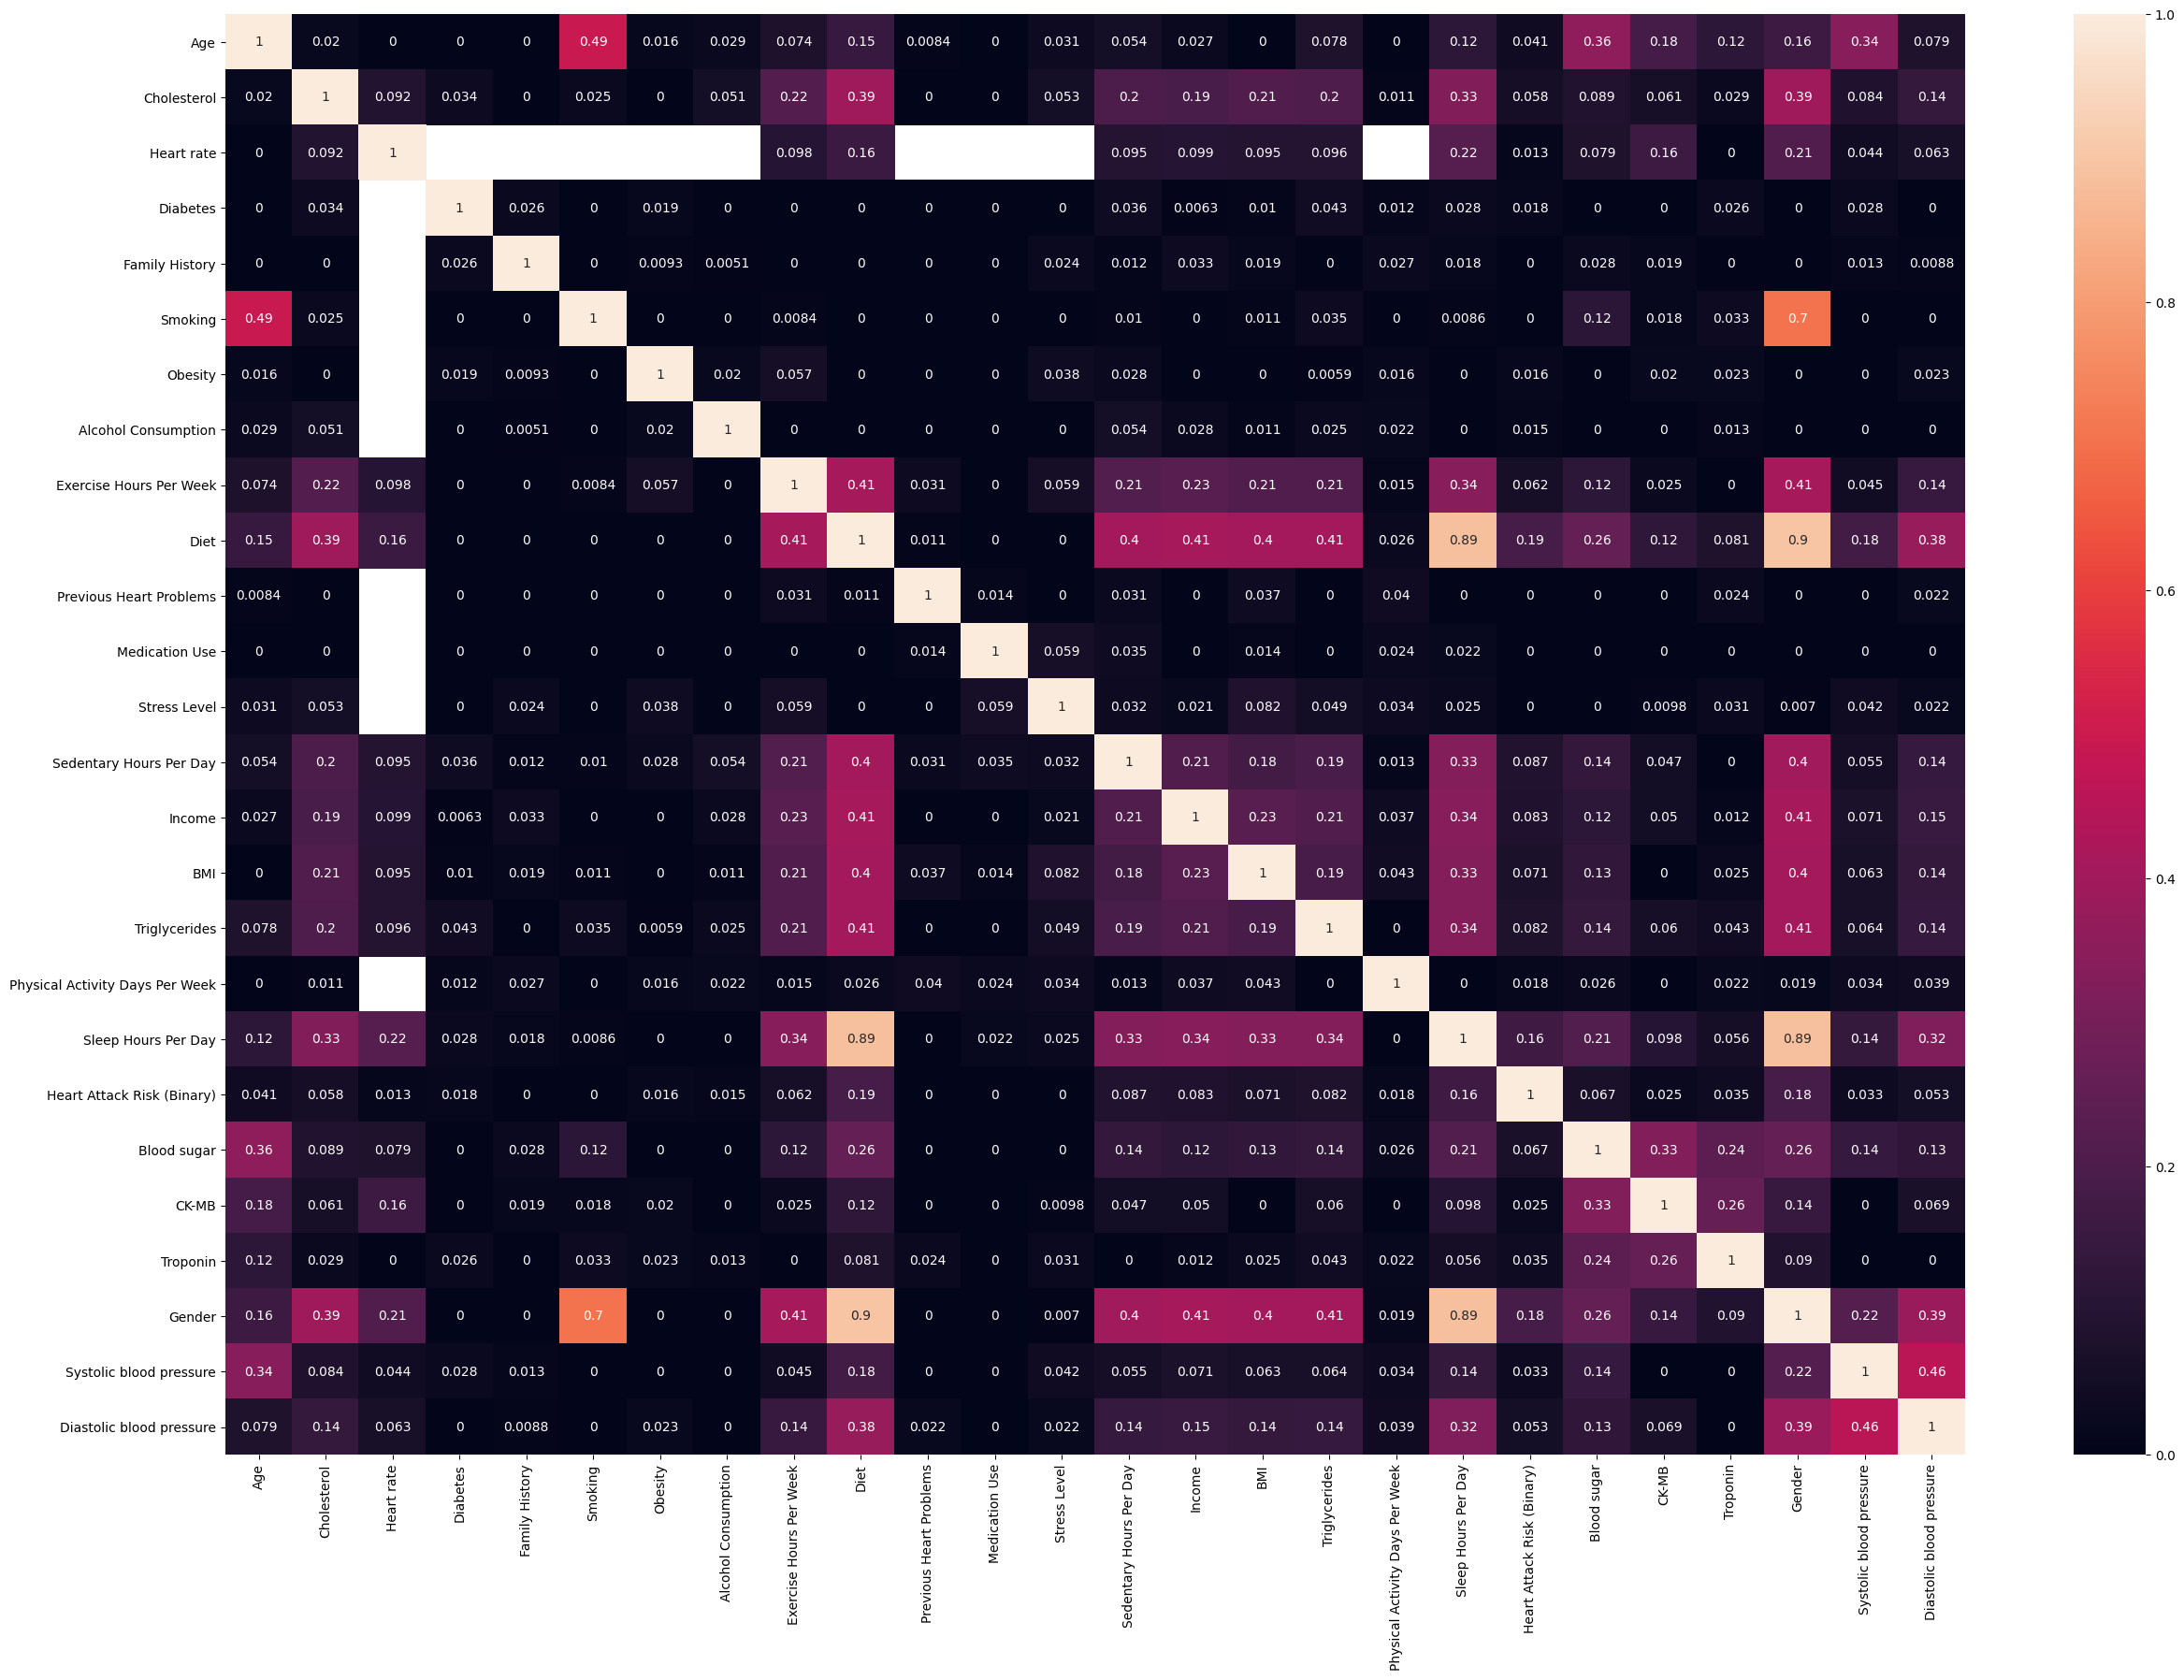

In [29]:
plt.figure(figsize=(30, 20))
sns.heatmap(df_train_2.phik_matrix(interval_cols=num_col), annot=True) 
plt.show()

### Удаление признаков не влияющих на таргет

In [30]:
df_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8685 entries, 1 to 9650
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level        

In [31]:
columns_to_drop = ['Family History', 'Smoking', 'Exercise Hours Per Week', 'Previous Heart Problems', 'Medication Use', 'Stress Level']
# Удаление колонок из DataFrame
df_train_3 = df_train_2.drop(columns=columns_to_drop)


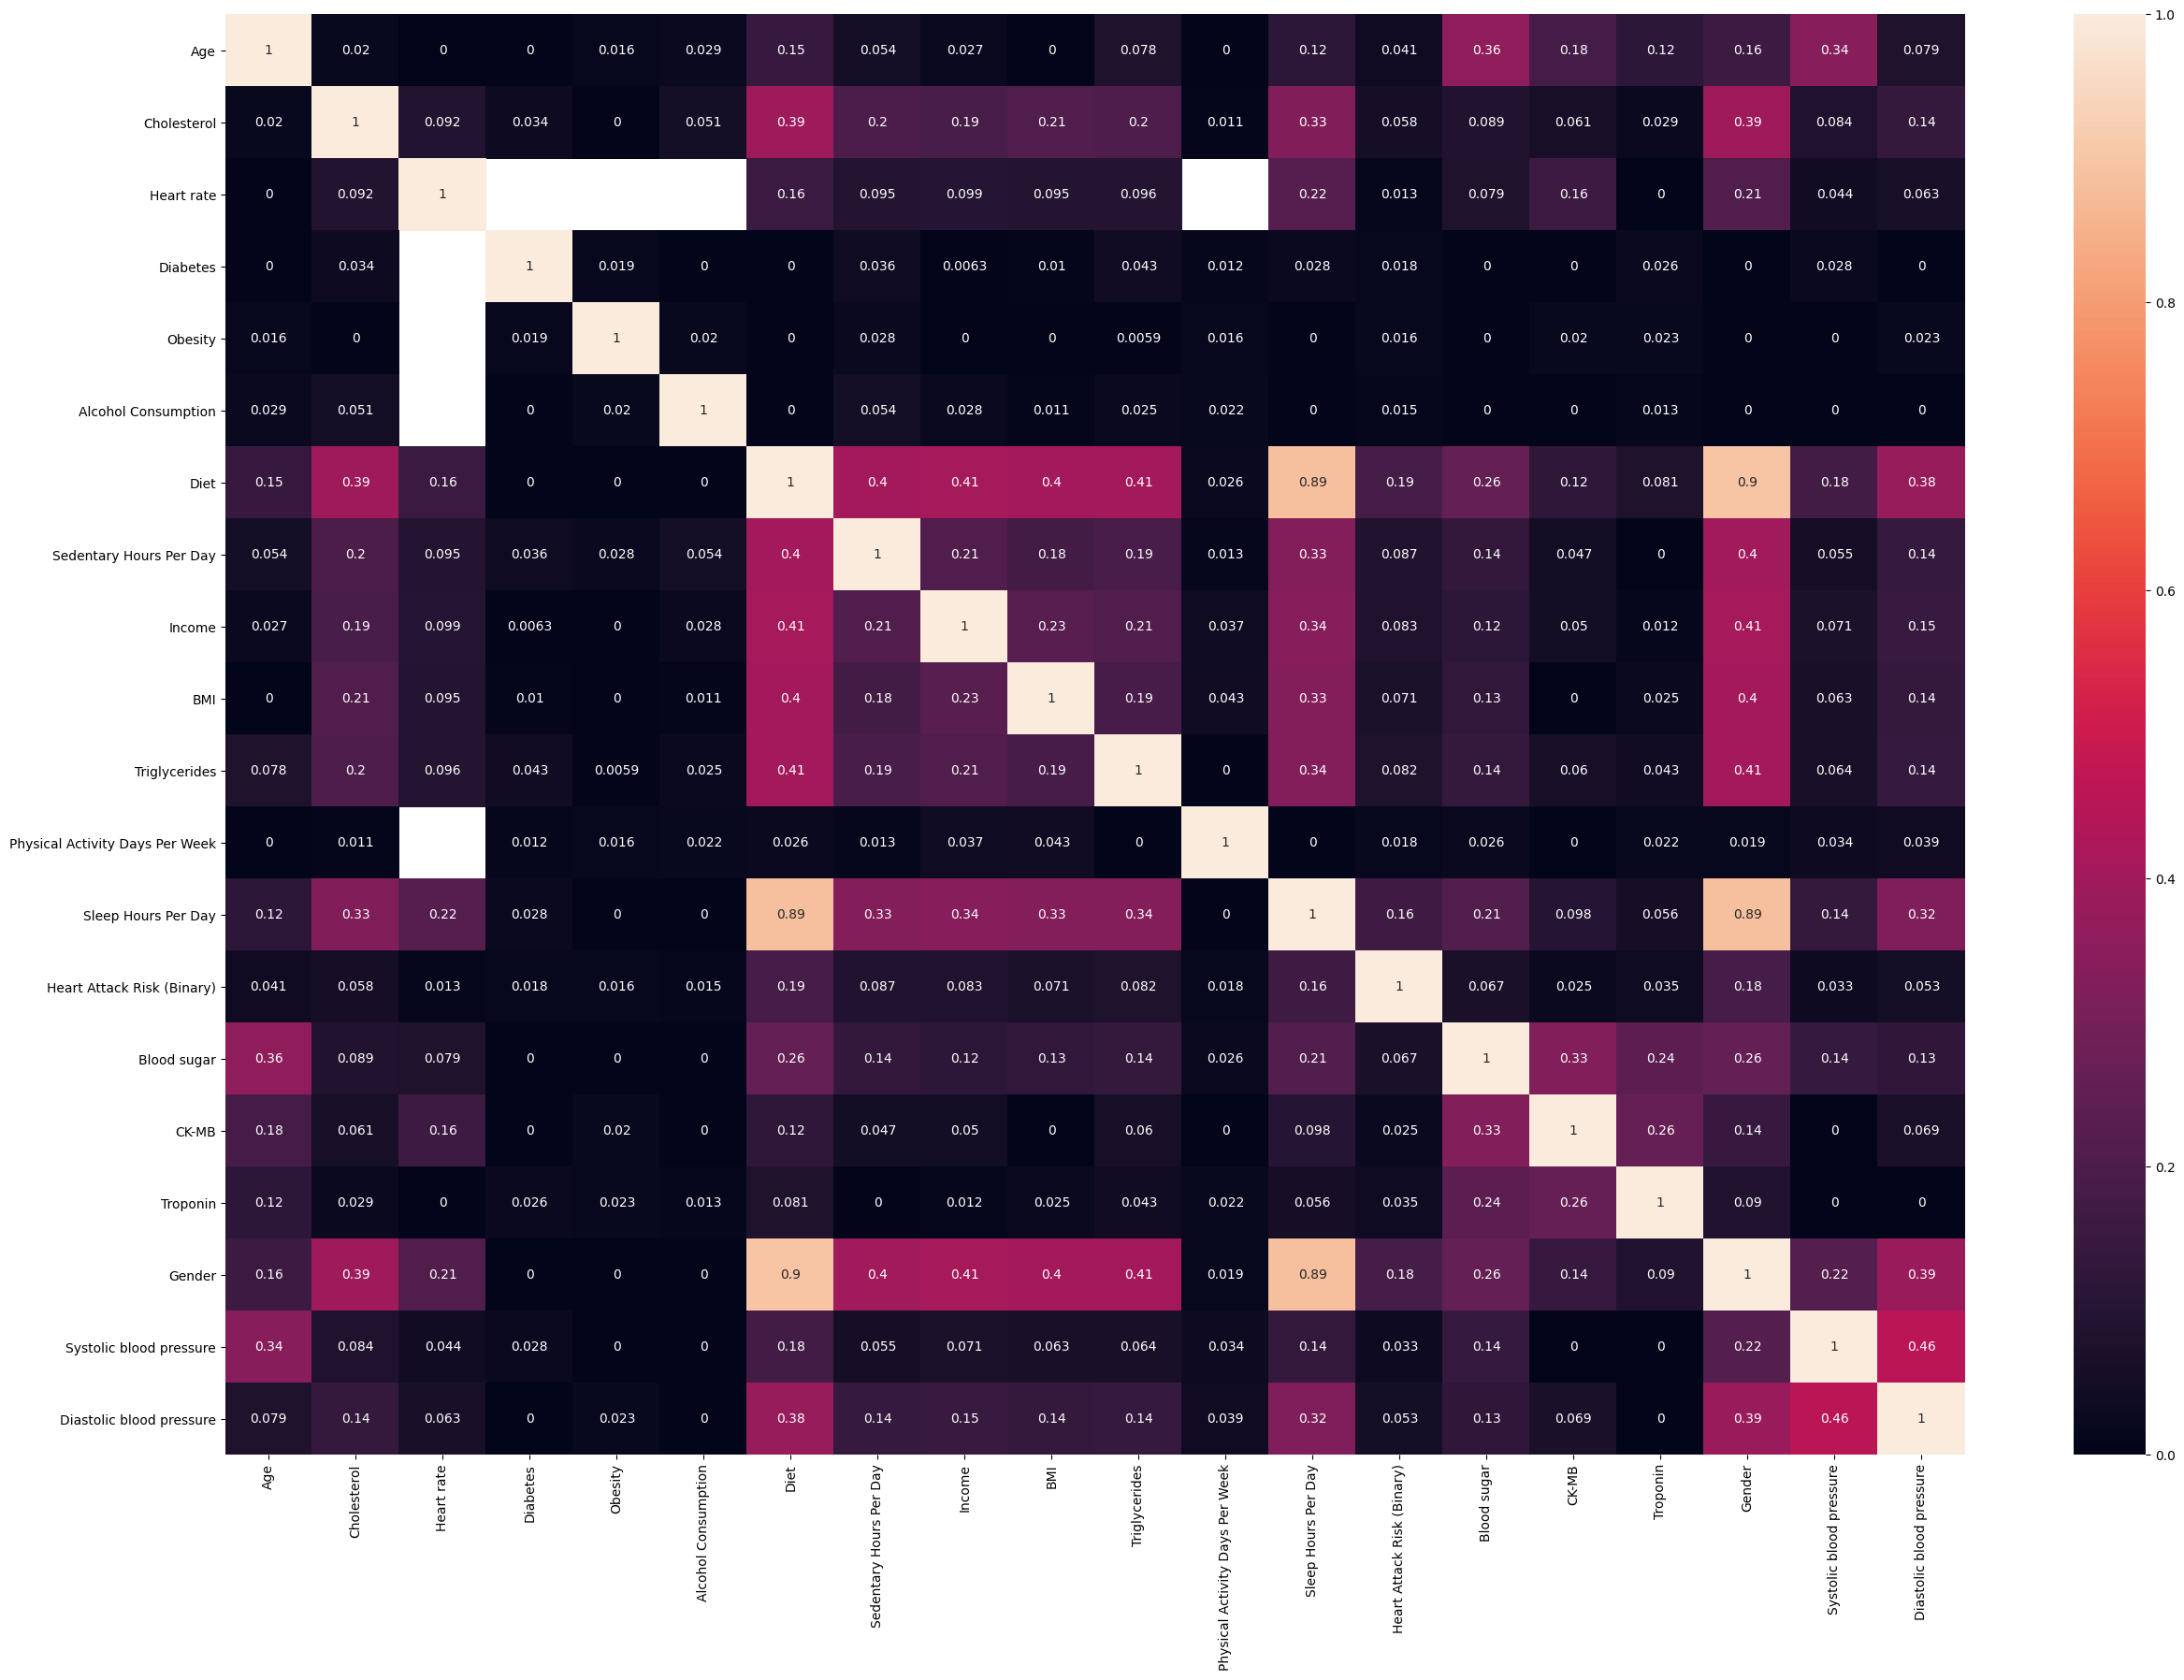

In [32]:
plt.figure(figsize=(30, 20))
sns.heatmap(df_train_3.phik_matrix(interval_cols=num_col), annot=True) 
plt.show()

### Вывод
Проанализированы утечки данных, проверена корреляция признаков. На основании построенной матрицы корреляции удалены признаки, имеющие коэффициенты ккорреляции 0 с целевым признаком 

## Catboost

Для построения модели предсказания выбран метод Catboost. Применение данного метода подразумевает обработку выбранных категориальных признаков имеющих тип с плавующей точкой в чсило или строку.

In [33]:
def convert_float_to_int(df, columns=None):  # Функция для преобразования float столбцов в int, если все значения имеют .0 и содержат только целые числа или пропуски
    if columns is None:
        columns = df.select_dtypes(include=['float64', 'float32']).columns
        
    for col in columns:
        # Проверяем, все ли значения имеют .0 или являются NaN
        if df[col].notna().all() and (df[col] % 1 == 0).all():
            # Преобразуем в int
            df[col] = df[col].astype(int)
        elif df[col].notna().sum() > 0 and (df[col].dropna() % 1 == 0).all():
            # Если есть пропуски, но остальные значения целые
            df[col] = df[col].fillna(-1).astype(int)  # или любое другое значение для NaN
            
    return df

In [34]:
convert_float_to_int(df_train_3, columns=None)

,Age,Cholesterol,Heart rate,Diabetes,Obesity,Alcohol Consumption,Diet,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,,
1,0.595506,0.096429,0.047663,1,1,1,1,0.710786,0.825422,0.274469,0.276623,2,0.666667,0,0.227018,0.048229,0.036512,Male,0.574194,0.569767
2,0.595506,0.189286,0.047663,0,0,1,2,0.320478,0.005041,0.890332,0.057143,4,1.000000,0,0.227018,0.048229,0.036512,Male,0.187097,0.674419
4,0.078652,0.792857,0.071494,1,1,0,2,0.315026,0.300191,0.169495,0.768831,1,0.166667,0,0.227018,0.048229,0.036512,Male,0.251613,0.383721
5,0.078652,0.771429,0.071494,1,0,1,2,0.910628,0.146060,0.394175,0.485714,2,0.666667,0,0.227018,0.048229,0.036512,Male,0.735484,0.383721
6,0.078652,0.492857,0.071494,1,0,0,1,0.583318,0.111129,0.834293,0.407792,0,1.000000,1,0.227018,0.048229,0.036512,Male,0.419355,0.720930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9646,0.404494,0.499780,0.091659,-1,-1,-1,3,0.499920,0.494889,0.494774,0.503603,-1,0.504621,0,0.081028,0.002029,0.006894,0.0,1.000000,1.000000
9647,0.235955,0.499780,0.049496,-1,-1,-1,3,0.499920,0.494889,0.494774,0.503603,-1,0.504621,0,0.084980,0.003500,0.000194,1.0,0.445161,0.186047
9648,0.348315,0.499780,0.088909,-1,-1,-1,3,0.499920,0.494889,0.494774,0.503603,-1,0.504621,0,0.330040,0.009540,0.000194,1.0,0.225806,0.302326


In [35]:
df_train_3['Age'] = df_train_2['Age'].astype(str).replace('nan', 'Unknown')
df_train_3['Sleep Hours Per Day'] = df_train_2['Sleep Hours Per Day'].astype(str).replace('nan', 'Unknown')

In [36]:
gender_mapping = {'Male': 1, 'Female': 0}
df_train_3['Gender'] = df_train_3['Gender'].replace(gender_mapping)
df_train_3['Gender'] = pd.to_numeric(df_train_3['Gender'], errors='coerce').astype('int64')

In [37]:
df_train_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8685 entries, 1 to 9650
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   object 
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8685 non-null   int32  
 4   Obesity                          8685 non-null   int32  
 5   Alcohol Consumption              8685 non-null   int32  
 6   Diet                             8685 non-null   int64  
 7   Sedentary Hours Per Day          8685 non-null   float64
 8   Income                           8685 non-null   float64
 9   BMI                              8685 non-null   float64
 10  Triglycerides                    8685 non-null   float64
 11  Physical Activity Days Per Week  8685 non-null   int32  
 12  Sleep Hours Per Day 

In [38]:
df_train_3.isna().sum()

Age                                0
Cholesterol                        0
Heart rate                         0
Diabetes                           0
Obesity                            0
Alcohol Consumption                0
Diet                               0
Sedentary Hours Per Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Heart Attack Risk (Binary)         0
Blood sugar                        0
CK-MB                              0
Troponin                           0
Gender                             0
Systolic blood pressure            0
Diastolic blood pressure           0
dtype: int64

In [39]:
nan_rows_info = df_train_3[df_train_3.isna().any(axis=1)]
for idx, row in nan_rows_info.iterrows():
    nan_cols = row.index[row.isna()].tolist()
    print(f"Строка {idx}: NaN в колонках {nan_cols}")

In [40]:
df_train_3['Heart Attack Risk (Binary)'].unique()

array([0, 1])

In [41]:
# Определение категориальных признаков
categorical_features = ['Age',
                        'Diabetes',
                        'Obesity',
                        'Alcohol Consumption',
                        'Diet',
                        'Physical Activity Days Per Week',
                        'Sleep Hours Per Day',
                        'Gender']

In [42]:
X = df_train_3.drop('Heart Attack Risk (Binary)', axis=1)
y = df_train_3['Heart Attack Risk (Binary)']



# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

model = CatBoostClassifier(
    cat_features=categorical_features,
    scale_pos_weight=scale_pos_weight,
    iterations=1000,
    learning_rate=0.05,
    verbose=100,
    random_state=42
)
model.fit(X_train, y_train, verbose=False)

# Оценка модели
predictions = model.predict(X_test)
recall = recall_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
print(f'Точность: {recall}')
print(f'Точность: {accuracy}')
print(f'Точность: {precision}')



print("Распределение классов:")
print(y.value_counts())

# Полный отчет по метрикам
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Точность: 0.4759535655058043
Точность: 0.5716753022452504
Точность: 0.4013986013986014
Распределение классов:
0    5672
1    3013
Name: Heart Attack Risk (Binary), dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.62      0.65      1134
           1       0.40      0.48      0.44       603

    accuracy                           0.57      1737
   macro avg       0.55      0.55      0.55      1737
weighted avg       0.59      0.57      0.58      1737



In [43]:
# Вероятности для класса 1
y_proba = model.predict_proba(X_test)[:, 1]

# Поиск оптимального порога для recall-score
best_threshold = 0.1
thresholds = [round(i,2) for i in np.linspace(best_threshold,1,num = 10,endpoint=False)]

best_recall = 0

for threshold in thresholds:
    y_pred_adj = (y_proba > threshold).astype(int)
    recall = recall_score(y_test, y_pred_adj)
    if recall > best_recall:
        best_recall = recall
        best_threshold = threshold

print(f"Оптимальный порог: {best_threshold:.2f}, recall-score: {best_recall:.3f}")

# Применить оптимальный порог
y_pred_optimized = (y_proba > best_threshold).astype(int)


Оптимальный порог: 0.10, recall-score: 1.000


In [44]:
X = df_train_3.drop('Heart Attack Risk (Binary)', axis=1)
y = df_train_3['Heart Attack Risk (Binary)']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

model_2 = CatBoostClassifier(
    cat_features=categorical_features,
    scale_pos_weight=scale_pos_weight,
    iterations=1000,
    learning_rate=0.05,
    verbose=100,
    random_state=42
)
model_2.fit(X_train_resampled, y_train_resampled, verbose=False)

# Оценка модели
predictions = model_2.predict(X_test)
recall = recall_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
print(f'Точность recall: {recall}')
print(f'Точность accuracy: {accuracy}')
print(f'Точность precision: {precision}')



#print("Распределение классов:")
#print(y.value_counts())

# Полный отчет по метрикам
#print("\nClassification Report:")
#print(classification_report(y_test, predictions))

Точность recall: 0.9071310116086235
Точность accuracy: 0.4386873920552677
Точность precision: 0.37312414733969984


In [45]:
# Вероятности для класса 1
y_proba = model_2.predict_proba(X_test)[:, 1]

# Поиск оптимального порога для recall-score
best_threshold = 0.5
thresholds = [round(i,2) for i in np.linspace(best_threshold,1,num = 10,endpoint=False)]

best_recall = 0
recall_scores = []
for threshold in thresholds:
    y_pred_adj = (y_proba > threshold).astype(int)
    recall = recall_score(y_test, y_pred_adj)
    recall_scores.append(recall)
    if recall > best_recall:
        best_recall = recall
        best_threshold = threshold
      

print(f"Оптимальный порог: {best_threshold:.2f}, recall-score: {best_recall:.3f}")

# Применить оптимальный порог
y_pred_optimized = (y_proba > best_threshold).astype(int)
print(recall_scores)

Оптимальный порог: 0.50, recall-score: 0.907
[0.9071310116086235, 0.8341625207296849, 0.7081260364842454, 0.5240464344941956, 0.3150912106135987, 0.15422885572139303, 0.07131011608623548, 0.014925373134328358, 0.001658374792703151, 0.0]


### Вывод

Выбраны категориальные признаки, Данные признаки переведены в строку или число. Проведено построение модели методорм Catboost. При построении модели ввиду дисбаланса классов использован undersampler. Для оценки модели использована метрика Recall. Результат метрики - Оптимальны порог 0,5, Recall 0.907.  

## Подготовка данных тестовой выборки

In [46]:
df_test = df_test.drop(columns=columns_to_drop)

In [47]:
convert_float_to_int(df_test, columns=None)

,Age,Cholesterol,Heart rate,Diabetes,Obesity,Alcohol Consumption,Diet,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,
0,0.595506,0.314286,0.047663,0,0,0,0,0.551234,0.862268,0.602363,0.332468,0,0.333333,0.227018,0.048229,0.036512,Male,0.600000,0.534884
3,0.078652,0.960714,0.071494,1,1,1,2,0.413584,0.949316,0.417945,0.266234,1,0.500000,0.227018,0.048229,0.036512,Male,0.645161,0.593023
10,0.786517,0.375000,0.048579,1,1,1,1,0.572033,0.187454,0.146128,0.971429,7,0.666667,0.227018,0.048229,0.036512,Female,0.593548,0.267442
14,0.584270,0.935714,0.066911,0,0,1,1,0.495582,0.633684,0.596568,0.279221,2,0.000000,0.227018,0.048229,0.036512,Male,0.690323,0.360465
19,0.853933,0.160714,0.058662,0,1,0,2,0.910359,0.681431,0.447749,0.297403,5,0.666667,0.227018,0.048229,0.036512,Male,0.625806,0.790698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9613,0.370787,0.499780,0.034830,-1,-1,-1,3,0.499920,0.494889,0.494774,0.503603,-1,0.504621,0.181818,0.011843,0.000194,1.0,0.419355,0.441860
9616,0.573034,0.499780,0.049496,-1,-1,-1,3,0.499920,0.494889,0.494774,0.503603,-1,0.504621,0.140316,0.013444,0.970871,1.0,0.483871,0.500000
9617,0.449438,0.499780,0.036664,-1,-1,-1,3,0.499920,0.494889,0.494774,0.503603,-1,0.504621,0.264822,0.008906,0.002136,1.0,0.380645,0.186047


In [48]:
df_test['Age'] = df_test['Age'].astype(str).replace('nan', 'Unknown')
df_test['Sleep Hours Per Day'] = df_test['Sleep Hours Per Day'].astype(str).replace('nan', 'Unknown')

In [49]:
gender_mapping = {'Male': 1, 'Female': 0}
df_test['Gender'] = df_test['Gender'].replace(gender_mapping)
df_test['Gender'] = pd.to_numeric(df_test['Gender'], errors='coerce').astype('int64')

In [51]:
predictions = model_2.predict(df_test)

# Создаем DataFrame с ID и предсказаниями
predictions_df = pd.DataFrame({
    'id': df_test.index,  # используем индекс как ID
    'prediction': predictions})
# predictions_df

,id,prediction
0,0,1
1,3,1
2,10,1
3,14,1
4,19,0
...,...,...
961,9613,0
962,9616,0
963,9617,0
964,9636,0


In [52]:
predictions_df.to_csv('predictions.csv', index=False)

### Вывод 
Построенная модель машинного обучения применена на тестовой предворительно обработанной выборки. Результат сохранен в файл CSV